In [2]:
import numpy as np 
import pandas as pd
import os 

In [3]:
for dirname, _, filenames in os.walk('/drive/MyDrive/Colab Notebooks/Stores sales time series/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
work_dir = 'content/drive/MyDrive/Colab Notebooks/Stores sales time series/'

In [34]:
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot
from learntools.time_series.utils import plot_lags, make_lags, make_leads
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split

import catboost as cb
from catboost import CatBoostRegressor
import lightgbm as lgb

In [27]:
!git clone https://github.com/Kaggle/learntools.git

Cloning into 'learntools'...
remote: Enumerating objects: 17929, done.
remote: Counting objects: 100% (309/309), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 17929 (delta 185), reused 201 (delta 111), pack-reused 17620
Receiving objects: 100% (17929/17929), 104.64 MiB | 14.76 MiB/s, done.
Resolving deltas: 100% (13297/13297), done.
Checking out files: 100% (653/653), done.


In [42]:
## Exploratory Data Analysis
train_data = pd.read_csv('train.csv')

In [31]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating learntools.egg-info
writing learntools.egg-info/PKG-INFO
writing dependency_links to learntools.egg-info/dependency_links.txt
writing top-level names to learntools.egg-info/top_level.txt
writing manifest file 'learntools.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'learntools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/learntools
copying learntools/__init__.py -> build/lib/learntools
creating build/lib/learntools/bqml
copying learntools/bqml/__init__.py -> build/lib/learntools/bqml
copying learntools/bqml/ex1.py -> build/lib/learntools/bqml
copying learntools/bqml/ex3.py -> build/lib/learntools/bqml
copying learntools/bqml/ex4.py -> build/lib/learntools/bqml
copying learntools/bqml/ex5.py -> build/lib/learntools/bqml
creating build/lib/learntools/computer_vision
copying learn

In [43]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.head

<bound method NDFrame.head of               id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         

In [33]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [44]:
holidays_data = pd.read_csv('holidays_events.csv')

In [45]:
holidays_data['date'] = pd.to_datetime(holidays_data['date'])
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [46]:
transactions_data = pd.read_csv('transactions.csv')

In [47]:
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
transactions_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [48]:
train_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [49]:
train_data['sales'] = np.log1p(train_data['sales'])


In [50]:
stores_data = pd.read_csv('stores.csv')
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [51]:
stores_data.shape


(54, 5)

Text(0.5, 1.0, 'Sales per month for each store')

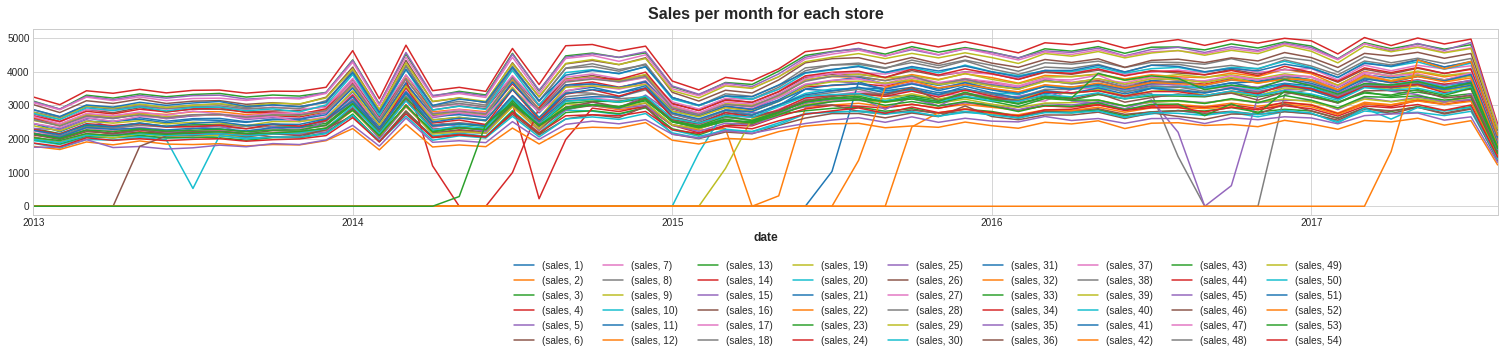

In [52]:
sales_per_store = (
    train_data
    .groupby(['date', 'store_nbr'])
    .aggregate({'sales': 'sum'})
    .unstack()
    .resample('1M')
    .sum()
)
sales_per_store.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(0.9,-.2), ncol=9)
plt.title("Sales per month for each store")

Text(0.5, 1.0, 'Sales per month for product family')

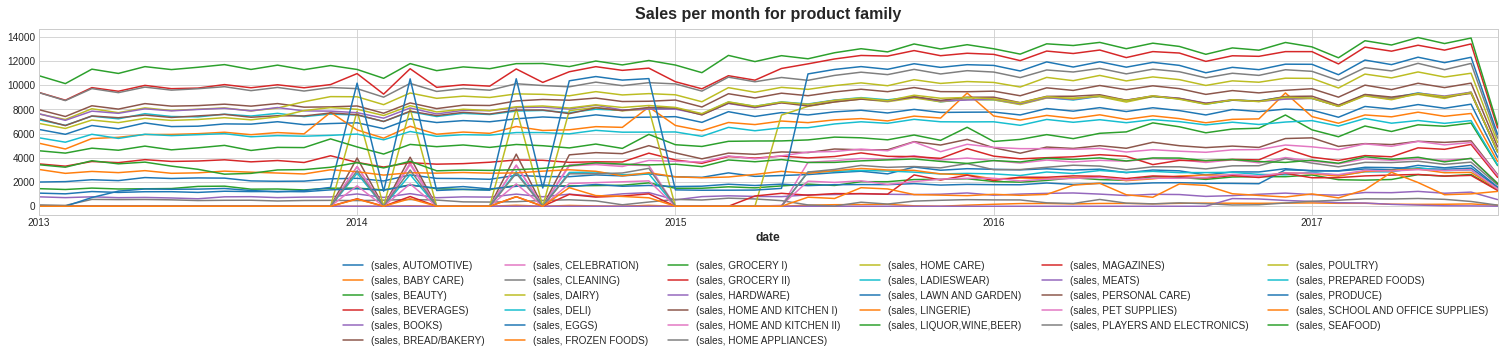

In [53]:
family_sales_per_month = (
    train_data
    .groupby(['date', 'family'])
    .aggregate({'sales': 'sum'})
    .unstack()
    .resample('1M')
    .sum()
)
family_sales_per_month.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(1, -.2), ncol=6)
plt.title("Sales per month for product family")

In [54]:
oil_data = pd.read_csv('oil.csv')
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [55]:
oil_data.isna().sum()


date           0
dcoilwtico    43
dtype: int64

In [56]:
oil_data.fillna(method = 'ffill', inplace = True)
oil_data['date'] = pd.to_datetime(oil_data['date'])

Text(0.5, 1.0, 'Oil price')

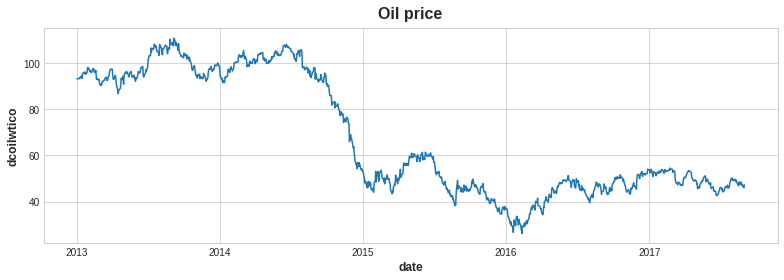

In [57]:
sns.lineplot(data=oil_data, x = 'date', y = 'dcoilwtico')
plt.title('Oil price')

**Checking Seasonal trends**


In [58]:
store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales.head()


sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

In [59]:
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)
average_sales.head()

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

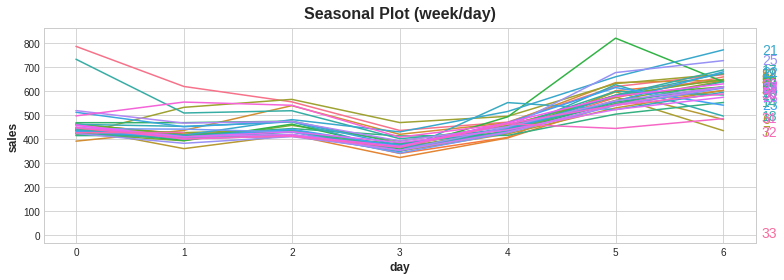

In [60]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day')

**Trying out a simple model with seasonality**


In [61]:
y = average_sales.copy()
fourier = CalendarFourier(freq="M", order = 4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    # YOUR CODE HERE
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()


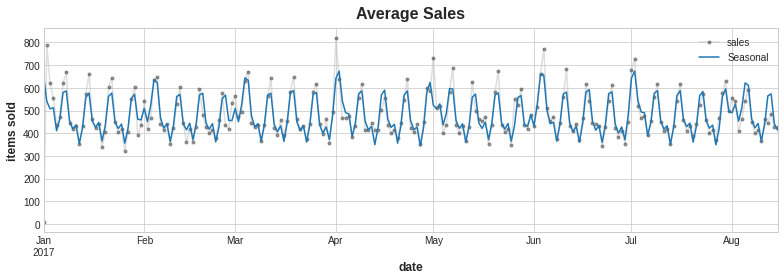

In [62]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)
y_pred = pd.Series(model.predict(X), index=X.index)
# Plot
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend()

**Comparing deseasonalized plot with original to check if all seasonality is accounted for**

Text(0.5, 1.0, 'Deseasonalized')

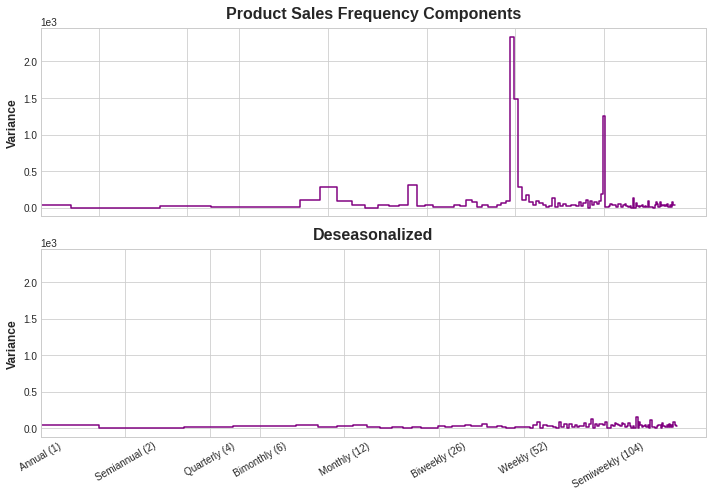

In [63]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title("Deseasonalized")

**Sales variation with holidays**

In [64]:
holidays_events = pd.read_csv(
    'holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


Text(0.5, 1.0, 'National and Regional Holidays')

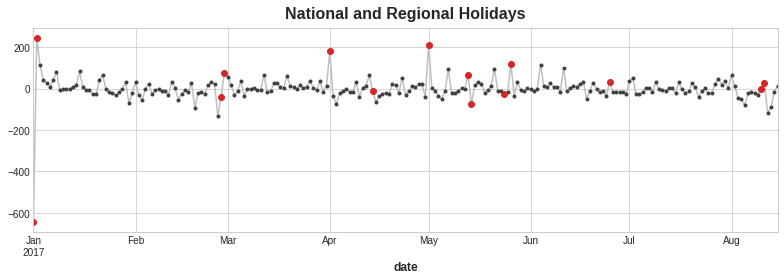

In [65]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays')

We can thus infer that there are seasonal trends for weekly, biweekly and monthly across all stores and the sales also depend on oil prices and holidays.

**Functions for feature generation**

In [66]:
# Function for adding lag features
def lag_features(df, lags):
    for lag in lags:
        df[f"sales_t-{lag}"] = df.groupby(["store_nbr", "family"])["sales"].transform(
            lambda x: x.shift(lag))
    return df

In [67]:
# Function for rolling average features
def roll_mean_features(df, windows):
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(["store_nbr", "family"])['sales']. \
                                                          transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=7, win_type="triang").mean()) + random_noise(
            df)
    return df

In [68]:
# Random Noise
def random_noise(df):
    return np.random.normal(scale=2.0, size=(len(df),))

In [69]:
# Function for ewm features
def ewm_features(df, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            df['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                df.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return df

In [70]:
# Calendar features
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    return df

In [71]:
# Function to fill missing values
def fill_na(df):
    df['holiday_type'] = df['holiday_type'].fillna('Common')
    df['locale'] = df['locale'].fillna('Common')
    df['description'] = df['description'].fillna('Unknown')
    df['transferred'] = df['transferred'].fillna(False)
    df['dcoilwtico'] = df['dcoilwtico'].fillna(method='backfill')
    return df

In [72]:
# To merge all the created features 
def merge_data(df):
    df = df \
        .merge(stores_data, left_on="store_nbr", right_on="store_nbr", how="left") \
        .rename(columns={"type": "store_type"}) \
        .merge(transactions_data, left_on=["date", "store_nbr"], right_on=["date", "store_nbr"], how="left") \
        .merge(holidays_data, left_on="date", right_on="date", how="left") \
        .drop_duplicates(subset="id") \
        .rename(columns={"type": "holiday_type"}) \
        .merge(oil_data, left_on="date", right_on="date", how="left") 
    return df

In [73]:
use_cols = ['date','store_nbr','family','sales','onpromotion','cluster','holiday_type', 
    'locale','description','transferred','dcoilwtico']

In [74]:
test_data = pd.read_csv(
   'test.csv'
)
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [75]:
test_id = test_data['id']
test_data['date'] = pd.to_datetime(test_data['date'])

**Adding features to complete dataset**

In [76]:
data = pd.concat([train_data, test_data], axis=0)
data = merge_data(data)
data = data[use_cols]
data = fill_na(data)
data = create_date_features(data)
data = lag_features(data, lags = [*range(1, 16), 16,17,18,19,20,21,22,30,31,90,180,364])
data = roll_mean_features(data,[16,17,18,30])

In [77]:
data = ewm_features(data, [0.95, 0.9, 0.8, 0.5],[1, 7,30])


In [78]:
data['store_nbr'] = data['store_nbr'].astype('category')
data['family'] = data['family'].astype('category')
data['store_nbr'] = data['store_nbr'].astype('category')
data['cluster'] = data['cluster'].astype('category')
data['family'] = data['family'].astype('category')
data['holiday_type'] = data['holiday_type'].astype('category')
data['locale'] = data['locale'].astype('category')
data['description'] = data['description'].astype('category')


In [79]:
data.head()


,date,store_nbr,family,sales,onpromotion,cluster,holiday_type,locale,description,transferred,...,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
data = data.query("date > '2013-12-31'")
X = data.query("date <= '2017-08-15'")
X_test = data.query("date > '2017-08-15'")
X.drop(['date'], inplace=True, axis=1)
X_test.drop(['date', 'year'], inplace=True, axis=1)

In [81]:
corr = X.corr()
corr['sales'].sort_values(ascending=False)

sales                         1.000000
sales_ewm_alpha_05_lag_1      0.973090
sales_ewm_alpha_08_lag_1      0.968657
sales_ewm_alpha_05_lag_7      0.966604
sales_ewm_alpha_09_lag_1      0.966508
sales_ewm_alpha_095_lag_1     0.965262
sales_ewm_alpha_08_lag_7      0.964625
sales_t-1                     0.963883
sales_ewm_alpha_09_lag_7      0.963186
sales_ewm_alpha_095_lag_7     0.962281
sales_t-7                     0.961233
sales_t-2                     0.958115
sales_t-3                     0.955286
sales_t-4                     0.953452
sales_t-6                     0.953263
sales_t-5                     0.952700
sales_t-14                    0.949117
sales_t-8                     0.949008
sales_t-9                     0.944701
sales_t-10                    0.942176
sales_t-13                    0.941201
sales_t-11                    0.940818
sales_t-12                    0.940049
sales_t-15                    0.937474
sales_t-21                    0.937108
sales_t-16               

**Sales v/s Other Features Correlation Heatmap**

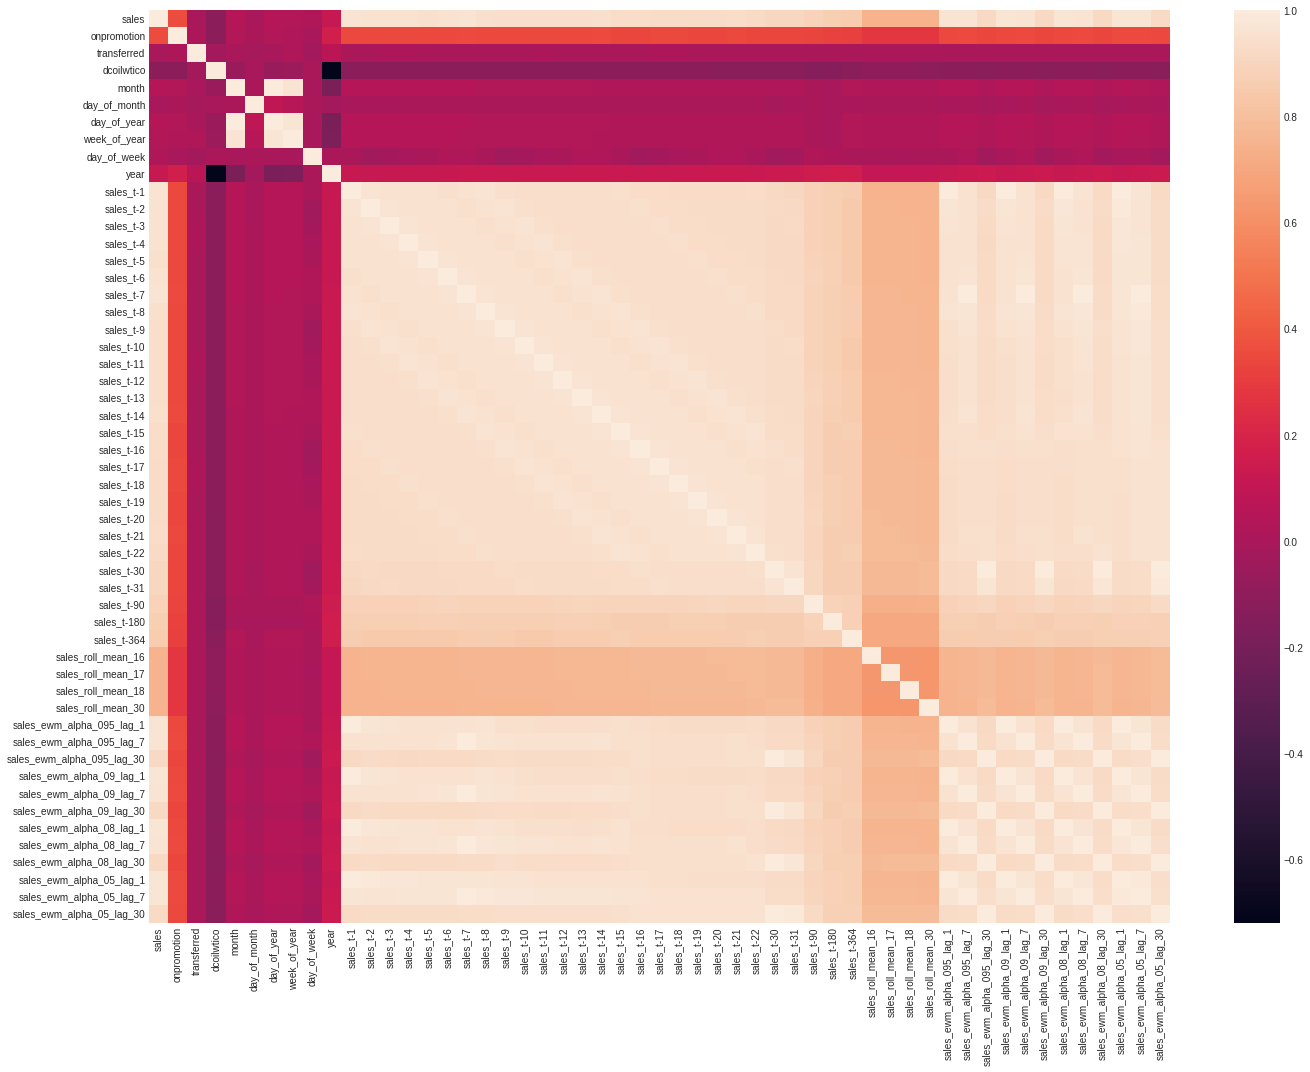

In [82]:
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, ax = ax)

In [83]:
Y = X['sales']
X = X.drop(['sales', 'year'], axis=1)
X_test = X_test.drop(['sales'], axis=1)

In [84]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [85]:
X_train.dtypes


store_nbr                     category
family                        category
onpromotion                      int64
cluster                       category
holiday_type                  category
locale                        category
description                   category
transferred                       bool
dcoilwtico                     float64
month                            int64
day_of_month                     int64
day_of_year                      int64
week_of_year                     int64
day_of_week                      int64
sales_t-1                      float64
sales_t-2                      float64
sales_t-3                      float64
sales_t-4                      float64
sales_t-5                      float64
sales_t-6                      float64
sales_t-7                      float64
sales_t-8                      float64
sales_t-9                      float64
sales_t-10                     float64
sales_t-11                     float64
sales_t-12               

**Models**

In [86]:
def recursive_predict(model):
    global X_test
    output = np.array([])
    for day in range(16, 32):
        pred = model.predict(X_test.query(f"day_of_month == {day}"))
        pred[pred < 0] = 0
        output = np.concatenate([output, pred], axis=0)
        for k in range(day+1, 32):
            X_test.loc[X_test[X_test["day_of_month"] == k].index, f"sales_t-{k-day}"] = pred
    return output

In [87]:
lgb_params = {
    'metric': 'mse',
    'boosting_type' : 'gbdt',
    'num_leaves': 8,
    'learning_rate': 0.2,
    'max_depth': 7,
    'verbose': 0,
    'num_boost_round': 5000,
    'early_stopping_rounds': 200,
    'nthread': -1,
    'force_col_wise': True,
}

train_dataset = lgb.Dataset(data=X_train, label=Y_train, feature_name='auto')
val_dataset = lgb.Dataset(data=X_val, label=Y_val, reference=train_dataset, feature_name='auto')

In [88]:
model = lgb.train(
    params=lgb_params, 
    train_set=train_dataset,
    valid_sets=[train_dataset, val_dataset],
    verbose_eval=100,
)

Training until validation scores don't improve for 200 rounds.
[100]	training's l2: 0.174422	valid_1's l2: 0.177243
[200]	training's l2: 0.160969	valid_1's l2: 0.164224
[300]	training's l2: 0.154404	valid_1's l2: 0.158011
[400]	training's l2: 0.150123	valid_1's l2: 0.154116
[500]	training's l2: 0.147142	valid_1's l2: 0.151359
[600]	training's l2: 0.144536	valid_1's l2: 0.148957
[700]	training's l2: 0.142566	valid_1's l2: 0.147268
[800]	training's l2: 0.140612	valid_1's l2: 0.14565
[900]	training's l2: 0.139096	valid_1's l2: 0.144387
[1000]	training's l2: 0.137742	valid_1's l2: 0.14332
[1100]	training's l2: 0.136549	valid_1's l2: 0.142474
[1200]	training's l2: 0.135518	valid_1's l2: 0.141789
[1300]	training's l2: 0.134537	valid_1's l2: 0.141141
[1400]	training's l2: 0.13369	valid_1's l2: 0.140546
[1500]	training's l2: 0.132906	valid_1's l2: 0.140157
[1600]	training's l2: 0.132092	valid_1's l2: 0.139733
[1700]	training's l2: 0.131399	valid_1's l2: 0.139354
[1800]	training's l2: 0.130666	

In [89]:
Y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
Y_val_pred[Y_val_pred < 0] = 0
print(np.sqrt(mean_squared_error(Y_val, Y_val_pred)))
print(mean_squared_log_error(np.expm1(Y_val), np.expm1(Y_val_pred)))

0.3662672132606316
0.134151671509709


In [90]:
rec_pred_lgb = recursive_predict(model)


In [91]:
X_test = data.query("date > '2017-08-15'")
X_test.drop(['date', 'year', 'sales'], inplace=True, axis=1)

In [92]:
cat_indices = np.where(X_train.dtypes == 'category')[0]
train_dataset_cb = cb.Pool(X_train, Y_train, cat_features=cat_indices)
val_dataset_cb = cb.Pool(X_val, Y_val, cat_features=cat_indices)

model_cb = CatBoostRegressor(
    loss_function='RMSE',
    cat_features=cat_indices,
    max_depth=7,
    n_estimators=100
)
model_cb.fit(train_dataset_cb, eval_set=val_dataset_cb)

Learning rate set to 0.5
0:	learn: 1.4628983	test: 1.4626866	best: 1.4626866 (0)	total: 1.49s	remaining: 2m 27s
1:	learn: 0.8812822	test: 0.8823942	best: 0.8823942 (1)	total: 2.53s	remaining: 2m 3s
2:	learn: 0.6365314	test: 0.6379357	best: 0.6379357 (2)	total: 3.52s	remaining: 1m 53s
3:	learn: 0.5459554	test: 0.5476304	best: 0.5476304 (3)	total: 4.68s	remaining: 1m 52s
4:	learn: 0.5151817	test: 0.5170111	best: 0.5170111 (4)	total: 5.67s	remaining: 1m 47s
5:	learn: 0.5005485	test: 0.5025834	best: 0.5025834 (5)	total: 7.06s	remaining: 1m 50s
6:	learn: 0.4889082	test: 0.4908199	best: 0.4908199 (6)	total: 8.65s	remaining: 1m 54s
7:	learn: 0.4816451	test: 0.4833236	best: 0.4833236 (7)	total: 9.7s	remaining: 1m 51s
8:	learn: 0.4752737	test: 0.4769575	best: 0.4769575 (8)	total: 10.6s	remaining: 1m 47s
9:	learn: 0.4705018	test: 0.4726067	best: 0.4726067 (9)	total: 11.4s	remaining: 1m 42s
10:	learn: 0.4646965	test: 0.4668391	best: 0.4668391 (10)	total: 12.3s	remaining: 1m 39s
11:	learn: 0.46056

In [93]:
Y_val_pred_cb = model_cb.predict(X_val)
Y_val_pred_cb[Y_val_pred_cb < 0] = 0
print(np.sqrt(mean_squared_error(Y_val, Y_val_pred_cb)))
print(mean_squared_log_error(np.expm1(Y_val), np.expm1(Y_val_pred_cb)))

0.3997926110774424
0.15983413187211915


In [94]:
rec_pred_cb = recursive_predict(model_cb)

In [95]:
X_test = data.query("date > '2017-08-15'")
X_test.drop(['date', 'year', 'sales'], inplace=True, axis=1)

In [96]:
final_submission = pd.DataFrame({'id': test_id, 'sales': np.expm1(rec_pred_lgb)})
final_submission.to_csv('submission.csv', index=False)